# Creating a Data Set of Job Postings From Scratch

## As a Data Scientist, in what city you will have the highest chance to get hired?

# Introduction:

I started this project when I was still living in Newfoundland and was working as a Data Scientist at the Center for Health Informatics and Analytics (CHIA). After a while I decided to move to another city and was curious to see how the job market is for Data Scientists in other cities. At first it was obvious that Toronto would have the highest number of <b>job postings</b> for data scientist, but I was also thinking that if you consider the high population of Toronto, then would you still say that if you move to Toronto, would you still have the highest chance of getting hired? In this project we will show that although Toronto has the highest nmuber of Data Science jobs, but you will have a higher chance in Vancouver and Waterloo to get hired, rather compared to Toronto. The picture below shows what this project will do<br><br>

<img src='intro.PNG' width=800px, height = '55%'>

This is what we are going to see in this project, but it is not the only thing we will do in this project. So for this project, the first an the most important thing we need is data, but how we are going to get this data? I wasn't able to find any open data online, so I decided to create my own data set from scratch. This is what we would also do in this project.

<b>Here we are going to create our own data set from real data.</b><br>
In fact, this article would also help you if you are a data scientist and want to work with some real data, so you can create your own data set of job postings. Here we will show how you can scrape the Internet to extract data and create your own real-life data set. The website that we are going to scrape is www.indeed.ca in order to extract job postings data.<br>
We will get the job titles, company name, location, job posting URL, and more importantly, the job description.
For this purpose.

In this notebook we will use:<br>

<b>BeautifulSoup</b> is a python library that lets you extract information from html and xml files. To see the documentation, pleae click <a href='https://www.crummy.com/software/BeautifulSoup/bs4/doc/'> here</a> 

<b>Pandas</b> for creating a data frame of the job postings data, and also for some data analysis<br><br>
<b>Matplotlib</b> for the visualization. We will create some basic graphs in the end. If you are not already familiar with Matplotlib please click <a href='https://matplotlib.org/'> here</a> <br><br>
We will use the BeautifulSoup python library for the scraping part, and after we have the data set ready, we will do some data visualizations with Matplotlib.<br><br>

Your questions and comments are welcome!




<h3>We will do this in five steps:<br></h3>
<ul>
<li> Importing the libraries<br>
<li> Creating a URL (a string) to brings us to the job posting site with the searching element we have defined<br>
<li> Getting the number of jobs that are found as our search result. We need this to loop over each and every job posting's URL, and then get the information. We need to know how many jobs and how many pages we are going to scrape<br>
<li> Extracting job postings information from the url and having them as a data frame<br>
<li> Saving the data into a CSV file<br>
<li> Doing some data cleansing
<li> Visualization of the distribution of the jobs by Canadian cities
    
</ul>

### We have done some Natural Language Processing and some more data analysis using this data set. If you are interested, please take a look <a href='https://www.crummy.com/software/BeautifulSoup/bs4/doc/'> here</a> 

# Coding:
## Importing the Libraries

In [16]:
import pandas as pd 
import matplotlib.pyplot as plt

import re # Regular expressions
from bs4 import BeautifulSoup # For HTML parsing
import math

import urllib.request as urllib2
from IPython.display import clear_output
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts


%matplotlib inline

# Creating the URL to indeed.ca:

The function below will create a URL to the job posting results. To create this URL, first we should go to indeed.ca and try searching a job to see how the URL is created. For example, if you try searching "Data Scientist" in "Toronto, ON", then you will se that the URL to the results is like: "https://www.indeed.ca/jobs?q=Data+Scientist&l=Toronto%2C+ON" (See the picture below). This is showing that the URL is consist of 67 parts:<br>
1) "https://www.indeed.ca/jobs?q=" <br>
2) "Data+Scientist" <br>
3) "&l=" <br>
4) "Toronto" <br>
5) "%2C+" <br>
6) "ON" <br>
<br><br><br>


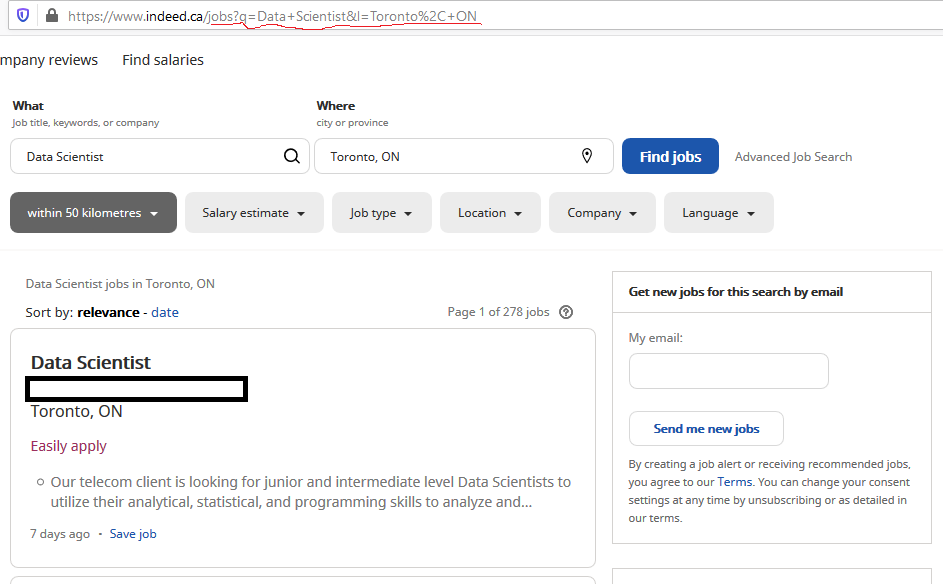

In [3]:
# This is a function that will create a URL to indeed.ca. The inputs to this function are job title, city, and province/state.

def create_URL(job, city, province):

    job = job.replace(' ','+') # Where the job title has two parts, in the URL there will be a + between the two parts.

    
    city = city.strip().replace(' ', '-') # Make sure the city specified works properly if it has more than one word (such as St. Johns) or it has leading or ending spaces
    site_list = ['http://www.indeed.ca/jobs?q=', job, '&l=', city,
                        '%2C+', province] # Joining all of our strings together to create the URL   
    if(city == ''):
        site_list = ['https://www.indeed.ca/jobs?q=', job , '&l=',province] # Creating the URL when city is not specified (is blank)

    final_URL = ''.join(site_list) # Merge the html address together into one string

    return final_URL

## Testing the function we just created (create_URL):<br>
Here we want to call the function with a job title, city and province to make sure the function will produce the right URL to a search result page from indeed.ca with the specified job title in the specified city.

In [4]:
print('Please click on the link below to visit the job posting results from indeed.ca. We are going to extract these job posting information:')
print(create_URL('Data Scientist','Toronto','ON'))

Please click on the link below to visit the job posting results from indeed.ca. We are going to extract these job posting information:
http://www.indeed.ca/jobs?q=Data+Scientist&l=Toronto%2C+ON


By clicking on the link you see that the results are exactly what we were looking for:<br><br>



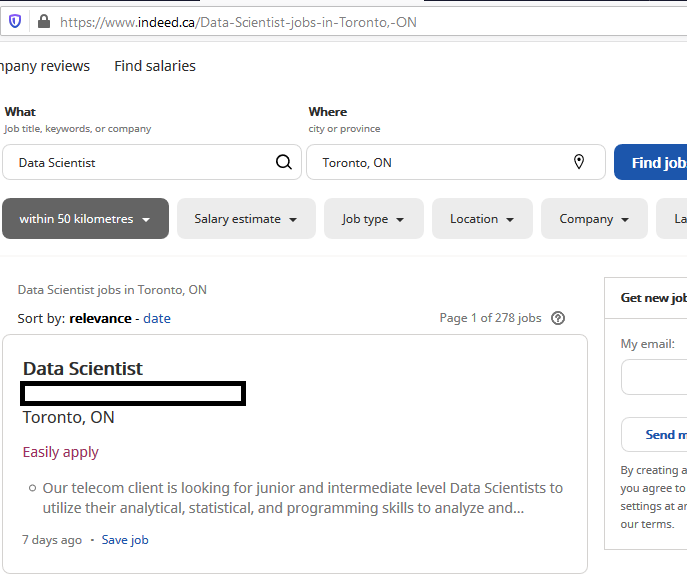



We are using the function below to get the number of jobs found after creating and opening the URL. This function gets a URL as input, and returns thow numbers, one is the number of jobs found in that URL, and the other is the number of pages<br><br>

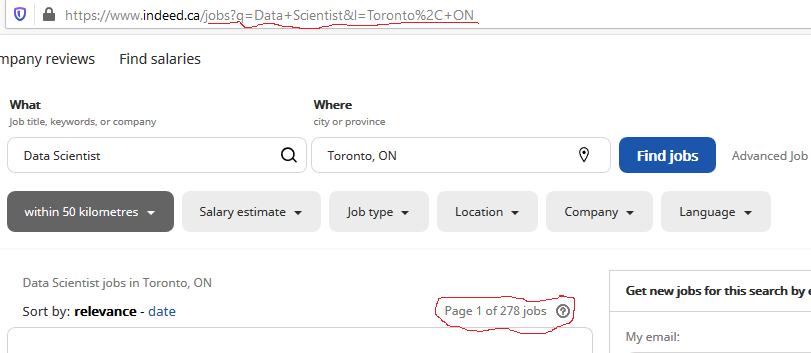

# Getting the Number of Jobs and Number of Pages:

In [5]:
def find_number_of_jobs(url):
    
    html = urllib2.urlopen(url).read() # Open up the URL
    soup = BeautifulSoup(html, 'lxml') # Get the html source from the URL

   
    # Now we will find out how many jobs there were

    num_jobs_string = soup.find(id = 'searchCountPages').string # searchCountPages is an html tag in the URL source that holds the number of jobs, 
                                                              # so we find it, then we get the string part out (check the screenshot below)

    job_numbers = re.findall('\d+', num_jobs_string) #Here we want to get the digits out of the string that we found in previous command. 

    if(len(job_numbers)>2): # If there are more than 999 jobs, then there will be a "," as a thousand separator, 
                                #so when we get the digits only, there will be two parts, numbers before "," and after it.
        total_num_jobs = int(job_numbers[1]) * 1000 + int(job_numbers[2]) 
    else:  
        total_num_jobs = int(job_numbers[1])

    num_pages = math.ceil(total_num_jobs/20) # In each page, there is usually more than 20 job postings, so we divide the number of jobs by 20, to get a rough 
                                             # estimation of the number of pages we need to scrape
                                          
    #job_descriptions = [] # Store all our descriptions in this list

    return total_num_jobs, num_pages

## This is the part in the html that we found the number of jobs: <br>

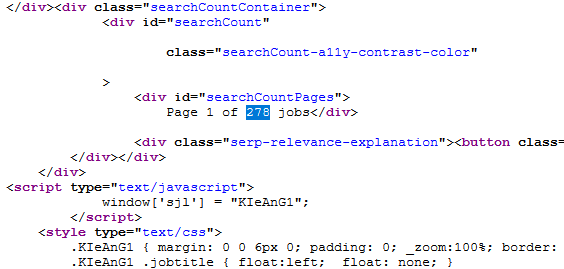

In [6]:
URL = create_URL('Data Scientist','Toronto','ON') # Getting all the jobs in Toronto

print('There are ',find_number_of_jobs(URL)[0], 'jobs available in',find_number_of_jobs(URL)[1], 'pages')

There are  264 jobs available in 14 pages


In [7]:
URL = create_URL('Data Scientist','','ON') # Getting all the jobs in all Ontario

print('There are ',find_number_of_jobs(URL)[0], 'jobs available in',find_number_of_jobs(URL)[1], 'pages')

There are  374 jobs available in 19 pages


# Getting the job posting information

In the function below, we are going to do the same thing we did for getting the number of jobs from the search result. It means we will check the html source code of the page to find the html tags that are holding the information we need such as job title, job location, company name, etc.

In [8]:
def extract_jobs(url):

    job_links = []
    companies = []
    job_titles = []
    job_links = []
    job_descriptions = []
    locations = []

    base_url = 'http://www.indeed.ca'

    for i in range(1,num_pages+1): # Loop through all of our search result pages
        clear_output() # We clear the output because we are going to print he URLs each time, and there will be alot of them.
        print ('Getting page', i)
        start_num = str(i*20-20) # Assign the multiplier of 20 to view the pages we want
        current_page = ''.join([url, '&start=', start_num]) # This is the URL that indeed uses for each page of the results. 
                                                            # For example, the second page of the results would have a URL like "https://www.indeed.ca/jobs?q=Data+Scientist&l=Toronto%2C+ON&start=20"
                                                            # Note the "&start=20" part in the URL.
        print(current_page)

        html_page = urllib2.urlopen(current_page).read() # Get the current page

        page_obj = BeautifulSoup(html_page, 'lxml')
        
        my_divs = page_obj.find_all("div") # We get all the div tags from the page
        counter=0
        for div in my_divs:
            if (div.find("div", class_="title")): # Finding a div that has a class='title'. That's where we can find that specific job posting's URL (because we want to capture the URL as well)
                job_link = str(div.a.get('href')) # Getting the URL part from the a tag inside the div tag we found.
                job_link = 'http://www.indeed.ca'+job_link # Because the URL that is inside the a tag is missing the base URL part, we add it manually.
                print(job_link)
                
                try: # need to open with try
                    job_page = urllib2.urlopen(job_link).read() # Now that we found the URL to the specific job posting, we open it
                    job_object = BeautifulSoup(job_page, 'lxml')
                    if(job_object.find("span", class_="jobsearch-JobMetadataHeader-iconLabel")): # This is the tag that holds the location of the job
                        job_location = job_object.find("span", class_="jobsearch-JobMetadataHeader-iconLabel").text

                    else:
                        job_location='' # We have this part in case if there is no location mentioned in the job add.

                    counter=counter+1    
                    if (job_object.find("div", class_="icl-u-lg-mr--sm icl-u-xs-mr--xs")): # This is the tag that has the company name
                        job_company_name = job_object.find("div", class_="icl-u-lg-mr--sm icl-u-xs-mr--xs").text
                    else:
                        job_company_name = 'Unknown' # If the company name is not accessible for any reason

                    if(job_object.find("div", class_="jobsearch-JobInfoHeader-title-container")): # The tag that has the job title
                        job_title = job_object.find("div", class_="jobsearch-JobInfoHeader-title-container").text
                    else:
                        job_title = 'Unknown'

                    if(job_object.find("div", id="jobDescriptionText")): # This is where we find the job description
                        job_description = job_object.find("div", id="jobDescriptionText").text
                    else:
                        job_description = 'Unknown'


                    # Adding the finding into lists so that we can create a data frame from these lists.
                    
                    companies.append(job_company_name)
                    job_titles.append(job_title)
                    job_links.append(job_link)
                    job_descriptions.append(job_description)
                    locations.append(job_location)
                    
                    
                # This is where we tell the function to continue if there is a 404 page not found error.    
                except urllib2.HTTPError as e:
                    if e.getcode() == 404: # check the return code
                        continue # If there is an error and the link is not accessible, continue to the next job posting URL.
                    raise # if other than 404, raise the error        
                

    # Now that we have extracted the information that we need, we put them into a data frame.
    dictionary = {'Job Title': job_titles, 'Company Name': companies,
                     'Location': locations, #'Key_to_Link':jks
                     'job URL': job_links,
                     'Job Description': job_descriptions,
                     }                 

    df = pd.DataFrame(dictionary)  
    
    
    filename='Jobs.csv'
    df.to_csv(filename)
    print ('*********************** Data was saved in',filename, 'file. *********************')
    df = df.drop_duplicates()
    df.head(3)
    return df
        

> # If you want to extract multiple jobs at once:

In [ ]:
jobs = ['Data Scientist', 'Carpenter', 'Registered Nurse', 'Custome Service Representative']


#job = ''
city = ''
state = 'ON'
dfs=[]

i=0
for job in jobs:
    i = i+1
    url = create_URL(job, city, state)
    
    print (url)
    total_num_jobs,num_pages  = find_number_of_jobs(url)
    print('The job title', job, 'has', total_num_jobs,'jobs in', num_pages,'pages')
    if (num_pages>50):
        num_pages = 50    
    df = extract_jobs(url)
    filename = 'Jobs_' + city.replace(' ','_') + '.csv'
    df.to_csv(filename)
    dfs.append(df) # This will give us a series of data frames that will need to be concatenated.


In [ ]:
# Checking to see if we have multiple data frames
print(dfs[0].head(3))
print(dfs[1].head(3))

In [ ]:
# Concatenating all data frames and saving the results into a csv file
df_all_jobs= pd.concat(dfs)
df_all_jobs.to_csv('All_Jobs.csv')

# Or if you want to get just one job title

In [ ]:
URL = create_URL('Data Scientist','','') # Getting all Data Scientist jobs within Canada
print(URL)
print('There are ',find_number_of_jobs(URL)[0], 'jobs available in',find_number_of_jobs(URL)[1], 'pages')
total_num_jobs,num_pages  = find_number_of_jobs(URL)
df = extract_jobs(URL)

# Data Cleansing

In [ ]:
df.keys()

In [10]:
#Getting rid of the extra column
df = df[['Job Title', 'Company Name', 'Location', 'job URL',
       'Job Description']]
df[6:9]

,Job Title,Company Name,Location,job URL,Job Description
6,Data Scientist,AstraZeneca,"Mississauga, ON",http://www.indeed.ca/rc/clk?jk=fa95daf5ee04790...,"At AstraZeneca, we are united by a common purp..."
7,Junior Data Scientist,Fiddlehead,"Moncton, NB",http://www.indeed.ca/rc/clk?jk=5337c492046faa6...,What you'll do\nResponsibilities\n\nIn this ro...
8,data scientist,ASTEK Canada Inc.,"Montréal, QC",http://www.indeed.ca/rc/clk?jk=f8616c72d121d97...,Bachelor's degree\n\n1 year to less than 2 yea...


# There may be some duplicate job postings and we need to remove
That is perhaps because indeed keeps showing the sponsored job ads on every page.

In [11]:
# There are still a lot of duplicate job postings:
df[df['Location']=='Welland, ON']

,Job Title,Company Name,Location,job URL,Job Description
48,Data Scientist,Canadian Tire,"Welland, ON",http://www.indeed.ca/rc/clk?jk=5660c56ba39fe2c...,Help us boldly shape retail in Canada\nCanadia...


In [12]:
# Removing the duplicate jobs

print('There are',len(df), 'jobs in the data set.\n')
df = df.drop_duplicates(subset = ['Job Title','Company Name','Location','Job Description'], keep="first")

print('There are',len(df), 'jobs in the data set after removing the duplicates.\n')
df = df.reset_index(drop=True)

There are 662 jobs in the data set.

There are 561 jobs in the data set after removing the duplicates.



## Missing values
We don't want to remove any data, so we will exchange missing values with "Unknown"

In [13]:
# Taking care of missing values
df = df.fillna('Unknown')

# Data Visualization

### Generating a bar chart for number of job postings by city:

In [14]:
# Getting number of job postings by city:
jobs_by_city= df.groupby('Location')['Job Title'].count().sort_values(ascending=False)[:10]
print("Number of jobs by city:\n\n ",jobs_by_city)

Number of jobs by city:

  Location
Toronto, ON        195
Montréal, QC       105
Vancouver, BC       56
Ottawa, ON          28
Calgary, AB         27
Brampton, ON        19
Mississauga, ON     18
Edmonton, AB        14
Markham, ON         10
Waterloo, ON         8
Name: Job Title, dtype: int64


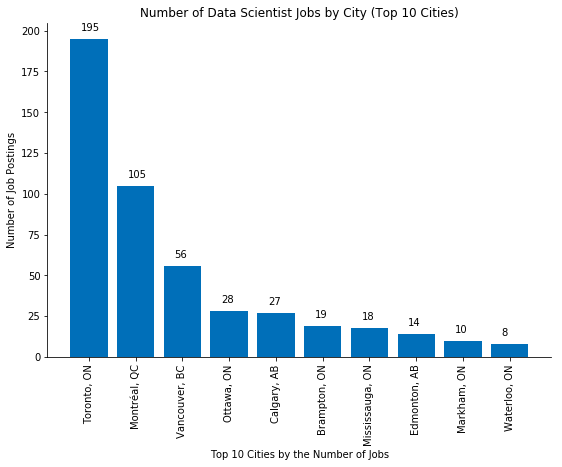

In [92]:
# Generating a bar chart for number of job postings by city:

# Getting number of job postings by city:
jobs_by_city= df.groupby('Location')['Job Title'].count().sort_values(ascending=False)[:10]



plt.figure(figsize=(10,8))
xvals = jobs_by_city.index
yvals = jobs_by_city.tolist()
plt.bar(xvals, yvals, color='#006fb9')
plt.xticks(rotation=90)
#plt.margins(0.2)

plt.subplots_adjust(bottom=0.3, left=0.2) # To make sure the x axis labels are visible
plt.title('Number of Data Scientist Jobs by City (Top 10 Cities)')
plt.xlabel('Top 10 Cities by the Number of Jobs')
plt.ylabel('Number of Job Postings')

#Having the y axis formatted as thousand separated in case there are more than a thousand jobs
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.spines['top'].set_visible(False) # Removing the top border
ax.spines['right'].set_visible(False) # Removing the righ border

for i, v in enumerate(yvals): # Showing the data values on top of the bars
    ax.text(i-0.17, v+5, str(v)) # i and v show the position of the data labels



# Reading population data

In [37]:
df_population = pd.read_csv('population.csv', encoding = "ISO-8859-1")

# Because in our job posting data set city column contains province 
# names as well (like Toronto, ON), so we have to change the 
#city name in the population data set too

df_population['City_Province'] = df_population['City'] + ', ' + df_population['Province']
df_population.head(30)


,City,Province,Population,City_Province
0,Toronto,ON,2731571,"Toronto, ON"
1,Montréal,QC,1704694,"Montréal, QC"
2,Calgary,AB,1239220,"Calgary, AB"
3,Ottawa,ON,934243,"Ottawa, ON"
4,Edmonton,AB,932546,"Edmonton, AB"
5,Mississauga,ON,721599,"Mississauga, ON"
6,Winnipeg,MB,705244,"Winnipeg, MB"
7,Vancouver,BC,631486,"Vancouver, BC"
8,Brampton,ON,593638,"Brampton, ON"
9,Hamilton,ON,536917,"Hamilton, ON"


In [38]:
print('The population data set has', len(df_population), 'rows (cities)')

The population data set has 26 rows (cities)


# Merging the Two Data Sets

In [39]:
# Getting number of Data Scientist jobs by city for the top 10 cities
jobs_by_city= df.groupby('Location')['Job Title'].count().sort_values(ascending=False)[:10]
df_jobs_by_city = jobs_by_city.reset_index()
df_jobs_by_city


,Location,Job Title
0,"Toronto, ON",195
1,"Montréal, QC",105
2,"Vancouver, BC",56
3,"Ottawa, ON",28
4,"Calgary, AB",27
5,"Brampton, ON",19
6,"Mississauga, ON",18
7,"Edmonton, AB",14
8,"Markham, ON",10
9,"Waterloo, ON",8


In [43]:
df_result.keys()

Index(['Location', 'Job Title', 'City', 'Province', 'Population',
       'City_Province'],
      dtype='object')

In [58]:
df_result = df_jobs_by_city.merge(df_population, how='inner', left_on='Location', right_on = 'City_Province')

# Renaming the column names
df_result.columns = ['Location', 'Number of Jobs', 'City', 'Province', 'Population',
       'City_Province']
df_result

,Location,Number of Jobs,City,Province,Population,City_Province
0,"Toronto, ON",195,Toronto,ON,2731571,"Toronto, ON"
1,"Montréal, QC",105,Montréal,QC,1704694,"Montréal, QC"
2,"Vancouver, BC",56,Vancouver,BC,631486,"Vancouver, BC"
3,"Ottawa, ON",28,Ottawa,ON,934243,"Ottawa, ON"
4,"Calgary, AB",27,Calgary,AB,1239220,"Calgary, AB"
5,"Brampton, ON",19,Brampton,ON,593638,"Brampton, ON"
6,"Mississauga, ON",18,Mississauga,ON,721599,"Mississauga, ON"
7,"Edmonton, AB",14,Edmonton,AB,932546,"Edmonton, AB"
8,"Markham, ON",10,Markham,ON,328966,"Markham, ON"
9,"Waterloo, ON",8,Waterloo,ON,104986,"Waterloo, ON"


In [59]:
# Calculating Rates:
# We are calculating rate of available data science jobs per 100,000 population
df_result['Rate per 100K'] = (df_result['Number of Jobs']/df_result['Population']*100000).round(1)
#df_result = df_result.sort_values(by='Rate per 100K', ascending=False)

df_result

,Location,Number of Jobs,City,Province,Population,City_Province,Rate per 100K
0,"Toronto, ON",195,Toronto,ON,2731571,"Toronto, ON",7.1
1,"Montréal, QC",105,Montréal,QC,1704694,"Montréal, QC",6.2
2,"Vancouver, BC",56,Vancouver,BC,631486,"Vancouver, BC",8.9
3,"Ottawa, ON",28,Ottawa,ON,934243,"Ottawa, ON",3.0
4,"Calgary, AB",27,Calgary,AB,1239220,"Calgary, AB",2.2
5,"Brampton, ON",19,Brampton,ON,593638,"Brampton, ON",3.2
6,"Mississauga, ON",18,Mississauga,ON,721599,"Mississauga, ON",2.5
7,"Edmonton, AB",14,Edmonton,AB,932546,"Edmonton, AB",1.5
8,"Markham, ON",10,Markham,ON,328966,"Markham, ON",3.0
9,"Waterloo, ON",8,Waterloo,ON,104986,"Waterloo, ON",7.6


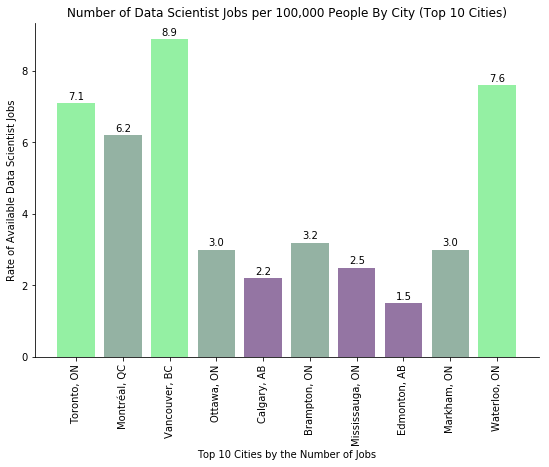

In [93]:
plt.figure(figsize=(10,8))
xvals = df_result['Location']
yvals = df_result['Rate per 100K'].tolist()

colors = []
for i in range(0, len(yvals)):
    if yvals[i] < 3:
        colors.append('#9475a3')
    elif yvals[i] < 6.6:
        colors.append('#94b2a3') 
    elif yvals[i] < 10:
        colors.append('#94f0a3')


plt.bar(xvals, yvals, color=colors)
plt.xticks(rotation=90)
#plt.margins(0.2)



plt.subplots_adjust(bottom=0.3, left=0.2) # To make sure the x axis labels are visible
plt.title('Number of Data Scientist Jobs per 100,000 People By City (Top 10 Cities)')
plt.xlabel('Top 10 Cities by the Number of Jobs')
plt.ylabel('Rate of Available Data Scientist Jobs')

#Having the y axis formatted as thousand separated in case there are more than a thousand jobs
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.spines['top'].set_visible(False) # Removing the top border
ax.spines['right'].set_visible(False) # Removing the righ border

for i, v in enumerate(yvals): # Showing the data values on top of the bars
    ax.text(i-0.17, v+0.1, str(v)) # i and v show the position of the data labels

